In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random as rn
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

2024-04-27 09:25:07.975155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 09:25:07.975287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 09:25:08.141510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [3]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'/kaggle/input/raw-dataset/raw_id.csv')

diagnosis_dict_binary = {
    0: 'NO DR',
    1: 'DR'
}

diagnosis_dict = {
    0: 'NO DR',
    1: 'DR'
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,DR (5),1,DR,DR
1,DR (1),1,DR,DR
2,DR (2),1,DR,DR
3,DR (3),1,DR,DR
4,DR (4),1,DR,DR


<Axes: ylabel='type'>

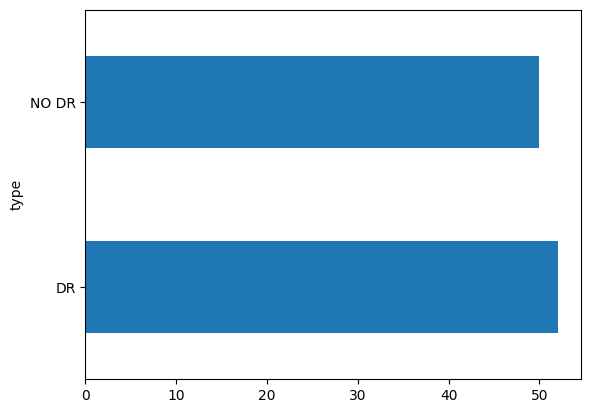

In [4]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

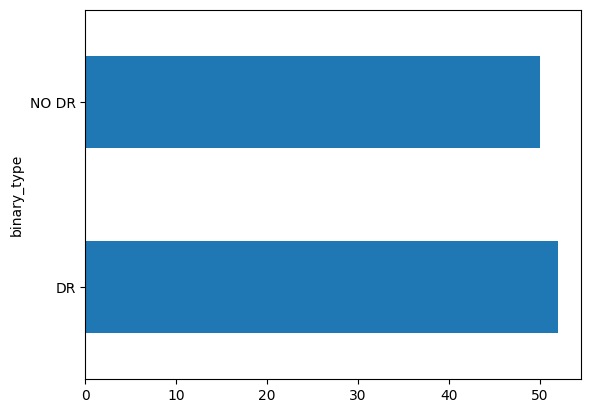

In [5]:
df['binary_type'].value_counts().plot(kind='barh')

In [6]:
os.environ['PYTHONHASHSEED'] = '0'

SEED = 1
np.random.seed(SEED)
rn.seed(SEED)

In [7]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'], random_state = SEED)
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'], random_state = SEED)

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
DR       36
NO DR    34
Name: count, dtype: int64 

type
NO DR    8
DR       8
Name: count, dtype: int64 

type
NO DR    8
DR       8
Name: count, dtype: int64 



In [8]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [9]:
# Copy images to respective working directory
src_dir = r'/kaggle/input/raw-dataset/Raw'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [10]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 70 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [11]:
# Define the custom CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),    Dense(128, activation='relu'),
    Dense(2, activation = 'softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_batches, batch_size=128, epochs=30, validation_data=(val_batches))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.3612 - loss: 1.6118 - val_accuracy: 0.5000 - val_loss: 0.7647
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5189 - loss: 0.7231 - val_accuracy: 0.5625 - val_loss: 0.6874
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5006 - loss: 0.6832 - val_accuracy: 0.5000 - val_loss: 0.6769
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4843 - loss: 0.6694 - val_accuracy: 0.5000 - val_loss: 0.6797
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4993 - loss: 0.6740 - val_accuracy: 0.7500 - val_loss: 0.6359
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7855 - loss: 0.6377 - val_accuracy: 0.7500 - val_loss: 0.6006
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7575 - loss: 0.5744 - val_accuracy: 0.7500 - val_loss: 0.5613
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7771 - loss: 0.5304 - val_accuracy: 0.7500 - val_loss: 0.5288
Epoch 9/30
3/3 ━━━━

In [12]:
# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,507,656 (127.82 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,438 (85.21 MB)

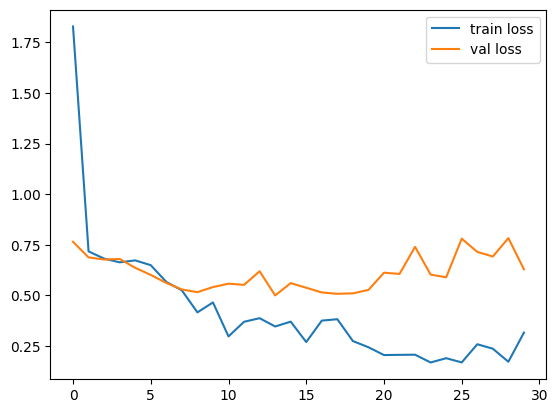

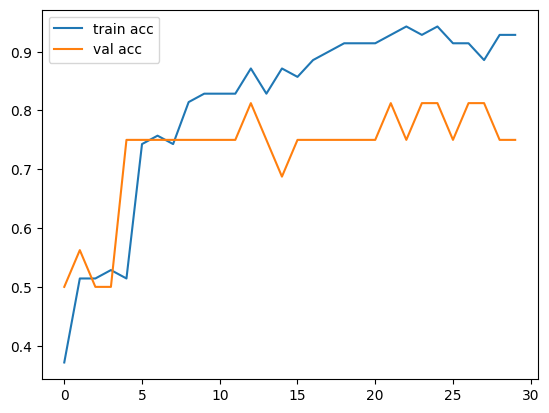

In [13]:
#loss graph
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.show()
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [14]:
# model.save('CNNv3-Raw.h5')

In [15]:
# fname = "weights-CNNv3-DR.weights.h5"
# model.save_weights(fname, overwrite = True)

In [24]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    r'/kaggle/working/test', # Put your path here
     target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

# predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
predictions = (model.predict(test_data_generator) > 0.5).astype("int32")
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 16 images belonging to 2 classes.


/tmp/ipykernel_33/1476124348.py:7: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [25]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [27]:
import sklearn.metrics as metrics

In [28]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

          DR       1.00      0.75      0.86         8
       NO DR       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16

